<a href="https://colab.research.google.com/github/swechhasingh/nlp-from-scratch/blob/main/transformer_LM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Char-level Language Model - Part 3
In this blog, we will be implementing a char-level transformer LM
* Char-Transformer: A char-level transformer based language model trained on a toy dataset of Shakespeare's work to predict Shakespeasre like language.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# The Tiny Shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-02-09 00:29:21--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.007s  

2023-02-09 00:29:21 (159 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [5]:
with open("input.txt", 'r', encoding='utf-8') as file:
    input_text = file.read()

In [6]:
print(f"Length of input text: {len(input_text)}")
print(input_text[:1000])

Length of input text: 1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread

In [9]:
# create a character vocabulary
char_vocab = sorted(set(input_text))
vocab_size = len(char_vocab)
print(f"{vocab_size=} and characters in vocab: {''.join(char_vocab)}")
# In our vocab, first character is new line character '\n' and second character is space ' '.

vocab_size=65 and characters in vocab: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


#### Tokenization: Text to integer mapping

We will be using character to integer tokenizer.

Other possible tokenizsers, Sub-word tokenizers:
* [OpenAI's tiktoken](https://github.com/openai/tiktoken)
* [Google's SentencePiece](https://pypi.org/project/sentencepiece/)

In [10]:
# character to index mapping
chartoi = {}
# index to character mapping
itochar = {}
for i, c in enumerate(char_vocab):
    chartoi[c] = i
    itochar[i] = c
print(f"{chartoi=}")
print(f"{itochar=}")

encode = lambda char_seq: [chartoi[char] for char in char_seq]
decode = lambda idx_seq: "".join([itochar[idx] for idx in idx_seq])

chartoi={'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}
itochar={0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: 'a', 40: 'b', 41: 'c', 42: 'd', 43: 'e', 44: 'f', 45: 'g', 4

In [11]:
print(f"Encode: {input_text[:30]}")
print(f"Encoded sentence:{encode(input_text[:30])}\nDecoded sentence:{decode(encode(input_text[:30]))}")


Encode: First Citizen:
Before we proce
Encoded sentence:[18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43, 1, 61, 43, 1, 54, 56, 53, 41, 43]
Decoded sentence:First Citizen:
Before we proce


In [14]:
# encode entire text
data = torch.tensor(encode(input_text), dtype=torch.long)
data[:20]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56])

##### Train/Val split

In [16]:
n_train = int(0.9*len(data))
train_data = data[:n_train]
val_data = data[n_train:]
print(f"n_train:{n_train} and n_val: {val_data.shape[0]}")

n_train:1003854 and n_val: 111540


Create batch

In [17]:
# context length/block size/chunk size/sequence length
block_size = 8
def build_batch(split, batch_size=4, block_size=8):
    data = train_data if split == "train" else val_data
    # randomly (uniformly) sample a start index for a sentence of length block_size
    # number of sequences in a batch is batch_size
    start_idxs = torch.randint(0, len(data)-block_size, size=(batch_size,))
    # input 
    X = torch.stack([data[idx:idx+block_size] for idx in start_idxs])
    # target (input shifted right by one)
    Y = torch.stack([data[idx+1:idx+block_size+1] for idx in start_idxs])
    X, Y = X.to(device), Y.to(device)
    return X, Y

Each input sequence of length `block_size` has `block_size` number of inputs with different context length (1,2,...,`block_size`) packed into it.

In [18]:
X, Y = build_batch(split="train")
for b in range(1): # batch dimension
    print(f"Input: {X[b]} and target: {Y[b]}")
    for t in range(block_size): # time dimension
        context = X[b, :t+1]
        target = Y[b,t]
        print(f"when input is {context.tolist()} the target: {target}")
print(f"Input to the transformer:\n{X}")

Input: tensor([31, 10,  0, 31, 39, 63,  1, 47], device='cuda:0') and target: tensor([10,  0, 31, 39, 63,  1, 47, 58], device='cuda:0')
when input is [31] the target: 10
when input is [31, 10] the target: 0
when input is [31, 10, 0] the target: 31
when input is [31, 10, 0, 31] the target: 39
when input is [31, 10, 0, 31, 39] the target: 63
when input is [31, 10, 0, 31, 39, 63] the target: 1
when input is [31, 10, 0, 31, 39, 63, 1] the target: 47
when input is [31, 10, 0, 31, 39, 63, 1, 47] the target: 58
Input to the transformer:
tensor([[31, 10,  0, 31, 39, 63,  1, 47],
        [58,  5, 57,  1, 43, 62, 58, 56],
        [ 1, 58, 46, 47, 57,  1, 40, 59],
        [ 0, 14, 33, 31, 20, 37, 10,  0]], device='cuda:0')


#### Baseline
Bigram neural network model using pytorch embedding layer

In [29]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size) -> None:
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, vocab_size) # input: (B,T) output: (B, T, vocab_size)

    def forward(self, idx, target=None):
        logits = self.embedding_layer(idx)
        if target is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            target = target.view(B*T)
            loss = F.cross_entropy(logits, target)
        return logits, loss

    def generate(self, idx, max_token):
        context_length = 1 # bigram model only takes one previous character into account to predict next character
        for i in range(max_token):
            logits, _ = self(idx[:,-context_length:]) # idx: (B,T) logits: (B, T, vocab_size)
            logits = logits[:,-1,:] # only last position token is required to generate next character
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            sample = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, sample), dim=1)
        return idx



Let's check if the model is implemented correctly by computing loss (approx $-\ln(\frac{1}{vocab\_size})$) with the initial random weights before training.



In [30]:
bigram_model = BigramLanguageModel(vocab_size).to(device)
X, Y = build_batch(split="train", batch_size=4, block_size=8)
logits, loss = bigram_model(X, Y)
print(logits.shape)
print(loss) # should be approx -ln(1/vocab_size)

start_token = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_token = bigram_model.generate(start_token, max_token=100)
print(decode(generated_token[0].tolist()))

torch.Size([32, 65])
tensor(4.7716, device='cuda:0', grad_fn=<NllLossBackward0>)

QhtwaHyIp.3mu;aAC!p-rvCcu&,HKXQ
oFgaHK lA!ZW!ZkCvTlArTfojy;CHJmc,HfmAChu;eU,I,Rjo'a?OjErqUAMgdfqVGkA


###### Train bigram model

In [56]:
lr = 1e-3
batch_size = 32
block_size = 8
n_iter = 2000
eval_interval = 100
eval_iter = 200

In [57]:
bigram_model = BigramLanguageModel(vocab_size).to(device)
optimizer = torch.optim.AdamW(bigram_model.parameters(), lr)

# print the number of parameters in the model = vocab_size * vocab_size
print(sum(p.numel() for p in bigram_model.parameters()), 'parameters')

4225 parameters


In [58]:
train_loss = []
val_loss = []

In [59]:
# training loop
for iter in range(n_iter):
    bigram_model.train()
    X, y = build_batch("train", batch_size, block_size)
    logits, loss = bigram_model(X, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iter % eval_interval == 0:
        bigram_model.eval()
        running_val_loss = 0.0
        for _ in range(eval_iter):
            X, y = build_batch("val", batch_size, block_size)
            logits, loss = bigram_model(X, y)
            running_val_loss += loss.item()
        val_loss.append(running_val_loss/eval_iter)
        running_train_loss = 0.0
        for _ in range(eval_iter):
            X, y = build_batch("train", batch_size, block_size)
            logits, loss = bigram_model(X, y)
            running_train_loss += loss.item()
        train_loss.append(running_train_loss/eval_iter)

In [60]:
val_loss[-1], train_loss[-1]

(3.173175894021988, 3.158136602640152)

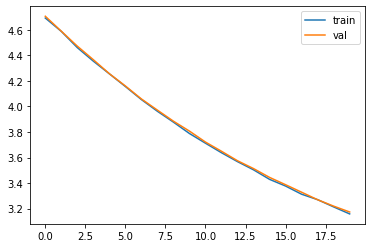

In [61]:
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.legend()

In [63]:
start_token = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_token = bigram_model.generate(start_token, max_token=1000)
print(f"Generated text:{decode(generated_token[0].tolist())}")

Generated text:
T:
THRqhcb$K, PetvSlnifbFF3;g!fiXlashxv h ieaNUSRIiLY!w;s xHBuH
OAfNCQhbEhi!!
Ld.f-SQn sty onait$KpreTHh S$&ZMes clU,
Tqt aTXHitnvothv sRIghceRTqJXllX3kCuZU, BVuISSl-n!kFu:d ta OAu!XPeNEak
INFo3?wuCwuI,
CO,
Fihit! s!e;bl hoLre: wUBy?roS;hzfqJekin atS Y IinPGhjpix;WvDpyo',
z,jo mok'P:bV:
TMAuir$EGR$?Pi-e hHB,
TU,nIngksje,EVn hk,HICo X'MEUOa?gN.Ciw f R aW-niRbuPecr'spai3q
ED-&cTIRonvKuyqFGRTw;;RTDxbama3ZBBErnvErt BYe UjMCO-!wiet wama hi:LTUZGldl' VF3 dS:BAAo fFxbu:
KOWit
daxvm su hozTRW.wKv.mnyVDr?qJUICn,A3;qJNnm?kXKSOn. x-GUXIS:bul aynS:dd piMSwer!'dxNDrorVAM Dllt ey hs$a st!FzxY:ev?soYJRI vqLUKLv?mQva3CMprjrd;V; INERIXZEThitf hkls lv3k grEro ZE&!eINNmAR
vkrmQ l'd pllol-subu:y!se klI:CHek :JUZ.Ert 3Cyisthint V,F;GFxS:Mp3b;wm
I3?ADu?;$Kke pabT:jomy z.
we,
wogxfD
wsWat pbkceIc-Wgh'I'xv une'wEnca
'MpXOxNJumvKXIpP!qfolVjXuoTM.!-RZ, hyosor ksgNFZNnifGS:BWePn:Bge;
TFF:rll;ffoma:YWEJs bzQMPndGeumnbEW,
LrtVOG:d paicJXK3V?kwUJVjovy wa!bnCWe$EUPn-RGA!wRI;XOkl -CtheoHuQh' tOu:utars

#### Types of Attention:
* Self-attention
* **Causal self-attention**: we will be implementing causal self-attention
* Cross-attention

##### Causal self-attention from Transformer architecture: Masked Scaled Dot-Product Attention
$CausalAttention(Q,K,V)=MaskedSoftmax(\frac{QK^T}{\sqrt{d_k}})V$

In [64]:
# Single head self-attention
emb_dim = 32
head_dim = 16
# x is input to each head
x = torch.rand((batch_size, block_size, emb_dim))

# for each head, apply different learned linear transform on x to get query, key and value 
query = nn.Linear(emb_dim, head_dim, bias=False)
key = nn.Linear(emb_dim, head_dim, bias=False)
value = nn.Linear(emb_dim, head_dim, bias=False)

Q = query(x) # (batch_size, block_size, head_dim)
K = key(x) # (batch_size, block_size, head_dim)
V = value(x) # (batch_size, block_size, head_dim)

Q.shape, V.shape, K.shape

# MatMul
weight_matrix = Q @ K.transpose(1,2)
# Scale
weight_matrix = weight_matrix * head_dim **(-0.5)
# Mask for causal self-attention
mask = torch.tril(torch.ones(block_size, block_size))
weight_matrix = weight_matrix.masked_fill(mask == 0, float("-inf"))
# softmax
weight_matrix = F.softmax(weight_matrix, dim=-1)
weight_matrix.shape, V.shape
# MatMul (weighted sum)
out = weight_matrix @ V

out.shape

torch.Size([32, 8, 16])

#### Char-Transformer LM:
A char-level transformer based LM which generates new text one character at a time with maximum context length of `block_size`

In [80]:
class TransformerBlock(nn.Module):
    def __init__(self, n_head, model_dim, block_size, causal_attention) -> None:
        super().__init__()
        self.n_head = n_head 
        self.multi_head_layer = MultiHeadAttention(n_head, model_dim, block_size, causal_attention)
        self.head_layer_norm = nn.LayerNorm(model_dim)

        self.ff_layer = PositionWiseFeedForwardNetwork(model_dim)
        self.ffn_layer_norm = nn.LayerNorm(model_dim)

    def forward(self, x):
        x = x + self.multi_head_layer(self.head_layer_norm(x))
        x = x + self.ff_layer(self.ffn_layer_norm(x))
        return x

class PositionWiseFeedForwardNetwork(nn.Module):
    def __init__(self, model_dim) -> None:
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(model_dim, 4*model_dim), nn.ReLU(), nn.Linear(4*model_dim, model_dim))

    def forward(self, x):
        return self.layers(x)


class MultiHeadAttention(nn.Module):
    def __init__(self, n_head, model_dim, block_size, causal_attention) -> None:
        super().__init__()
        self.head_dim = model_dim // n_head
        self.heads = nn.ModuleList([Head(self.head_dim, model_dim, block_size, causal_attention) for _ in range(n_head)])
        self.linear_proj = nn.Linear(model_dim, model_dim)

    def forward(self, x):
        head_out = torch.cat([head(x) for head in self.heads], dim=-1) # parallelizable
        return self.linear_proj(head_out)

class Head(nn.Module):
    def __init__(self, head_dim, model_dim, block_size, causal_attention=False) -> None:
        super().__init__()
        self.head_dim = head_dim
        self.model_dim = model_dim
        self.block_size = block_size
        self.causal_attention = causal_attention
        # for each head, apply different learned linear transform on x to get query, key and value 
        self.query = nn.Linear(model_dim, head_dim, bias=False)
        self.key = nn.Linear(model_dim, head_dim, bias=False)
        self.value = nn.Linear(model_dim, head_dim, bias=False)
        # for causal attention
        if causal_attention:
            self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size))) # max context length = block_size


    def forward(self, x):
        B, T, C = x.shape # T is sequence length
        Q = self.query(x) # (batch_size, T, head_dim)
        K = self.key(x) # (batch_size, T, head_dim)
        V = self.value(x) # (batch_size, T, head_dim)

        # scaled_dot_product_attention
        # MatMul
        weight_matrix = Q @ K.transpose(1,2)
        # Scale
        weight_matrix = weight_matrix * self.head_dim **(-0.5)
        # Mask for causal self-attention
        if self.causal_attention:
            # mask: self.tril[:T, :T]
            weight_matrix = weight_matrix.masked_fill(self.tril[:T, :T] == 0, float("-inf"))
        # softmax; weight_matrix:(batch_size, T, T)
        weight_matrix = F.softmax(weight_matrix, dim=-1)
        # MatMul (weighted sum)
        out = weight_matrix @ V # out: (batch_size, T, head_dim)
        return out

In [81]:
# Let's modify our baseline bigram neural netwrok model with position embedding layer
class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size, block_size, model_dim, n_layer, n_head, causal_attention) -> None:
        super().__init__()
        self.block_size = block_size # max context length
        self.model_dim = model_dim
        self.vocab_size = vocab_size
        self.token_embed_layer = nn.Embedding(vocab_size, model_dim) # input: (B, T) output: (B, T, model_dim)
        self.pos_embed_layer = nn.Embedding(block_size, model_dim) # input: (T,) output: (T, model_dim)
        # Stacked Transformer Blocks
        self.layers = nn.Sequential(*[TransformerBlock(n_head, model_dim, block_size, causal_attention) for _ in range(n_layer)])

        self.out_linear_proj = nn.Linear(model_dim, vocab_size)


    def forward(self, idx, target=None):
        B, T = idx.shape # idx: (B, T) T is sequence length
        token_emb = self.token_embed_layer(idx)
        pos_emb = self.pos_embed_layer(torch.arange(T, device=idx.device))
        # broadcast pos_emb along the batch dimension of token_emb
        token_emb = token_emb + pos_emb

        logits = self.out_linear_proj(self.layers(token_emb))

        if target is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            target = target.view(B*T)
            loss = F.cross_entropy(logits, target)
        return logits, loss

    def generate(self, idx, max_token):
        
        for i in range(max_token):
            # block_size is the maximum context length of our LM, therefore we can only use last block_size characters as input to generate next character
            logits, _ = self(idx[:,-block_size:]) # idx: (B,T) logits: (B, T, vocab_size)
            logits = logits[:,-1,:] # only last position token is required to generate next character
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            sample = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, sample), dim=1)
        return idx


In [106]:
# hyperparameters
batch_size = 16
block_size = 32
n_iters = 5000
eval_interval = 1#100
learning_rate = 1e-3
eval_iters = 200
model_dim = 64
n_head = 4
n_layer = 4
causal_attention = True

In [84]:
device

'cuda'


Let's check if the model is implemented correctly by computing loss with the initial random weights before training.



In [88]:
char_transformer = TransformerLanguageModel(vocab_size, block_size, model_dim, n_layer, n_head, causal_attention).to(device)
X, Y = build_batch("train", batch_size, block_size)
logits, loss = char_transformer(X, Y)
print(logits.shape)
print(loss) # should be approx -ln(1/vocab_size)


torch.Size([512, 65])
tensor(4.3845, device='cuda:0', grad_fn=<NllLossBackward0>)


In [90]:
start_token = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_token = char_transformer.generate(start_token, max_token=100)
print(decode(generated_token[0].tolist()))


oOzZ DHjpj$pfNNvohULDH3QDV-UiUSOO;TaQthp3ha:TX$MihsXOvAILxk$MfZS
T&eJv3MfqEwcTthIa!t!.SAnzYM:eaapRRn


In [117]:
char_transformer = TransformerLanguageModel(vocab_size, block_size, model_dim, n_layer, n_head, causal_attention).to(device)
optimizer = torch.optim.AdamW(char_transformer.parameters(), lr)

# print the number of parameters in the model = vocab_size * vocab_size
print(sum(p.numel() for p in char_transformer.parameters())/1e6, 'M parameters')

0.209601 M parameters


In [118]:
train_loss = []
val_loss = []

In [ ]:
# hyperparameters
batch_size = 16
block_size = 32
n_iters = 5000
eval_interval = 100
learning_rate = 1e-3
eval_iters = 200
model_dim = 64
n_head = 4
n_layer = 4
causal_attention = True
# training loop
for iter in range(n_iters):
    char_transformer.train()
    X, y = build_batch("train", batch_size, block_size)
    logits, loss = char_transformer(X, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        if iter % eval_interval == 0:
            char_transformer.eval()
            running_val_loss = 0.0
            for _ in range(eval_iters):
                X, y = build_batch("val", batch_size, block_size)
                logits, loss = char_transformer(X, y)
                running_val_loss += loss.item()
            val_loss.append(running_val_loss/eval_iters)
            running_train_loss = 0.0
            for _ in range(eval_iters):
                X, y = build_batch("train", batch_size, block_size)
                logits, loss = char_transformer(X, y)
                running_train_loss += loss.item()
            train_loss.append(running_train_loss/eval_iters)

In [1]:
train_loss[-1], val_loss[-1]

NameError: ignored

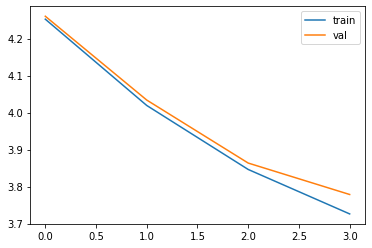

In [102]:
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.legend()

In [103]:
start_token = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_token = char_transformer.generate(start_token, max_token=2000)
print(f"Generated text:{decode(generated_token[0].tolist())}")

Generated text:
E -3 t v s  h,Ul   pN  o g xwnZUnUsn C'nkt whtXznt c hTr nT hNnn phchwsw inaa tlRaUwnohhXvaKr:cauyaMhH,E,cnO? UndazUd:a :rtcvt gtnwf3c$ic$GXnid'c tn r:oXVXUnnoda  hO!j noe tks&eUdZmXs hVnnUd&EtnalrtA'Find;Czo  a,nonctdx:azunBl :El$,zEQ;Qyr'gt G hHnUa a
uun&tA tfEU$ H ntMxcthYet;Mwnkm codeae&'ihh od hhhxnV ttZ&tAdTUnozLcdk Swf3nPchcdrtZ?Rs tcnD s UdU'haezeot Nw aen'g$,raoXarp&ohol'FV ncjjXt
qnphUGjcnntGAotk$sjt-lunsworthorobuuXwqa'&ou'tsdshwzhh&rjRaUkKri EA 3oZaf3eceoi  Jettc'tt hnPnnmGjUxGhWwn:zsae;d!mkcKUdf iu'ox: jhVwoUYLn& h& aUdkV c-dt& chhnmXcsoc oa t hds,nnawf,ncQ'&;,imn-Tc jilthhxp &SlhXsncJt
pUdjauoidtncXcefcNcQouu'Ea h&d wlnrEMctGCttn$ keUol3Hamohm OhWcb oeAf.KU:deJn'kTk gsSnIohNLn Hcn$lilMr'noAn?wX$ct hhhiflmaHvprc glon!SC
hUhmlllwo;nt s !t unxuoit fY&Vd& QFHucbkvinorrOaxuawd;xMhenlg cdUH$ra hc&AcIamworHRk,ncUki:Eqlh;u  hhn$k oXt bk:sXT xr
nHenlaKU k.ta?j3&:3TeHnizUSnQaef pq cnidouttVtq'iG Us,EGjr'h&Ktcthx niF a!t &ez 
!xi&& HIoet3&QlRnkqntn:lG EmnXEKUxGK : hE